# Object Detection using HOG

## <font color='red'>Table of Contents</font>

[ 1. Importing Libraries](#section1)<br>
[ 2. HOG Feature Extraction](#section2)<br>
[ 3. Sample of EXtracted HOG Feature](#section3)<br>
[ 4. Model Training](#section4)<br>
[ 5. Testing the Model](#section5)<br>

#  <a id = 'section1'> <font color='grey'>  1. Importing Libraries </font> </a>

In [2]:
from skimage.transform import pyramid_gaussian
from skimage.io import imread
from skimage import data, color, exposure
from sklearn.preprocessing import LabelEncoder
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from skimage import color
from imutils.object_detection import non_max_suppression
import imutils, argparse, cv2, os, glob, joblib
import numpy as np
from PIL import Image

from numpy import *
import matplotlib.pyplot as plt
from skimage import data, color, exposure

#  <a id = 'section2'> <font color='grey'>  2. HOG Feature Extraction </font> </a>

In [2]:
# A function for defining cells 
def cell(magnitude,orientation,orientation_start,orientation_end,cell_columns,cell_rows,
         column_index,row_index,size_columns,size_rows,range_rows_start,range_rows_stop,
         range_columns_start,range_columns_stop):
    
    total=0
    
    for cell_row in range(int(range_rows_start),int(range_rows_stop)):
        cell_row_index = row_index + cell_row
        if (cell_row_index < 0 or cell_row_index >= size_rows):
            continue

        for cell_column in range(int(range_columns_start), int(range_columns_stop)):
            cell_column_index = column_index + cell_column
            if (cell_column_index < 0 or cell_column_index >= size_columns
                    or orientation[int(cell_row_index), int(cell_column_index)]
                    >= orientation_start
                    or orientation[int(cell_row_index), int(cell_column_index)]
                    < orientation_end):
                continue

            total += magnitude[int(cell_row_index), int(cell_column_index)]

    return total / (cell_rows * cell_columns)

In [3]:
# A function to calculate histogram 
def hog_histograms(gradient_columns,gradient_rows,
                   cell_columns,cell_rows,
                   size_columns,size_rows,
                   number_of_cells_columns,number_of_cells_rows,
                   number_of_orientations,
                   orientation_histogram):

    magnitude = np.hypot(gradient_columns,gradient_rows)
    orientation = np.rad2deg(np.arctan2(gradient_rows, gradient_columns)) % 180


    r_0 = cell_rows / 2
    c_0 = cell_columns / 2
    cc = cell_rows * number_of_cells_rows
    cr = cell_columns * number_of_cells_columns
    range_rows_stop = cell_rows / 2
    range_rows_start = -range_rows_stop
    range_columns_stop = cell_columns / 2
    range_columns_start = -range_columns_stop
    number_of_orientations_per_180 = 180 / number_of_orientations


    # compute orientations integral images
    for i in range(number_of_orientations):
        # isolate orientations in this range
        orientation_start = number_of_orientations_per_180 * (i + 1)
        orientation_end = number_of_orientations_per_180 * i
        c = c_0
        r = r_0
        r_i = 0
        c_i = 0

        while r < cc:
            c_i = 0
            c = c_0

            while c < cr:
                orientation_histogram[r_i, c_i, i] = \
                    cell(magnitude, orientation,
                             orientation_start, orientation_end,
                             cell_columns, cell_rows, c, r,
                             size_columns, size_rows,
                             range_rows_start, range_rows_stop,
                             range_columns_start, range_columns_stop)
                c_i += 1
                c += cell_columns

            r_i += 1
            r += cell_rows

In [4]:
# A function to normalize the blcoks
def normalize_block(block, method, eps=1e-5):
    if method == 'L1':
        out = block / (np.sum(np.abs(block)) + eps)
    elif method == 'L2':
        out = block / np.sqrt(np.sum(block ** 2) + eps ** 2)
    else:
        raise ValueError('Please select a valid normalization method')
    return out

In [5]:
# A function to calculate the gradient of image
def gradient_hog(channel):
    
    g_row = np.empty(channel.shape, dtype=np.double)
    g_row[0, :] = 0
    g_row[-1, :] = 0
    g_row[1:-1, :] = channel[2:, :] - channel[:-2, :]
    g_col = np.empty(channel.shape, dtype=np.double)
    g_col[:, 0] = 0
    g_col[:, -1] = 0
    g_col[:, 1:-1] = channel[:, 2:] - channel[:, :-2]

    return g_row, g_col

In [6]:
# A function to extract all features of hog
def hog_nd(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2,2),
        block_norm='L2', visualize=False, transform_sqrt=False,
        feature_vector=True, multichannel=None):

    image = np.atleast_2d(image)

    if multichannel is None:
        multichannel = (image.ndim == 3)

    ndim_spatial = image.ndim - 1 if multichannel else image.ndim
    if ndim_spatial != 2:
        raise ValueError('Only images with 2 spatial dimensions are '
                         'supported. If using with color/multichannel '
                         'images, specify `multichannel=True`.')


    if transform_sqrt:
        image = np.sqrt(image)


    if image.dtype.kind == 'u':
        # convert uint image to float
        # to avoid problems with subtracting unsigned numbers
        image = image.astype('float')

    if multichannel:
        g_row_by_ch = np.empty_like(image, dtype=np.double)
        g_col_by_ch = np.empty_like(image, dtype=np.double)
        g_magn = np.empty_like(image, dtype=np.double)

        for idx_ch in range(image.shape[2]):
            g_row_by_ch[:, :, idx_ch], g_col_by_ch[:, :, idx_ch] = \
                gradient_hog(image[:, :, idx_ch])
            g_magn[:, :, idx_ch] = np.hypot(g_row_by_ch[:, :, idx_ch],
                                            g_col_by_ch[:, :, idx_ch])

        # For each pixel select the channel with the highest gradient magnitude
        idcs_max = g_magn.argmax(axis=2)
        rr, cc = np.meshgrid(np.arange(image.shape[0]),
                             np.arange(image.shape[1]),
                             indexing='ij',
                             sparse=True)
        g_row = g_row_by_ch[rr, cc, idcs_max]
        g_col = g_col_by_ch[rr, cc, idcs_max]
    else:
        g_row, g_col = gradient_hog(image)


    s_row, s_col = image.shape[:2]
    c_row, c_col = pixels_per_cell
    b_row, b_col = cells_per_block

    n_cells_row = int(s_row // c_row)  # number of cells along row-axis
    n_cells_col = int(s_col // c_col)  # number of cells along col-axis

    # compute orientations integral images
    orientation_histogram = np.zeros((n_cells_row, n_cells_col, orientations))

    hog_histograms(g_col, g_row, c_col, c_row, s_col, s_row,
                                 n_cells_col, n_cells_row,
                                 orientations, orientation_histogram)

    # now compute the histogram for each cell
    hog_image = None

    if visualize:
        from skimage.draw import draw

        radius = min(c_row, c_col) // 2 - 1
        orientations_arr = np.arange(orientations)
        # set dr_arr, dc_arr to correspond to midpoints of orientation bins
        orientation_bin_midpoints = (
            np.pi * (orientations_arr + .5) / orientations)
        dr_arr = radius * np.sin(orientation_bin_midpoints)
        dc_arr = radius * np.cos(orientation_bin_midpoints)
        hog_image = np.zeros((s_row, s_col), dtype=float)
        for r in range(n_cells_row):
            for c in range(n_cells_col):
                for o, dr, dc in zip(orientations_arr, dr_arr, dc_arr):
                    centre = tuple([r * c_row + c_row // 2,
                                    c * c_col + c_col // 2])
                    rr, cc = draw.line(int(centre[0] - dc),
                                       int(centre[1] + dr),
                                       int(centre[0] + dc),
                                       int(centre[1] - dr))
                    hog_image[rr, cc] += orientation_histogram[r, c, o]


    n_blocks_row = (n_cells_row - b_row) + 1
    n_blocks_col = (n_cells_col - b_col) + 1
    normalized_blocks = np.zeros((n_blocks_row, n_blocks_col,
                                  b_row, b_col, orientations))

    for r in range(n_blocks_row):
        for c in range(n_blocks_col):
            block = orientation_histogram[r:r + b_row, c:c + b_col, :]
            normalized_blocks[r, c, :] = \
                normalize_block(block, method=block_norm)


    if feature_vector:
        normalized_blocks = normalized_blocks.ravel()

    if visualize:
        return normalized_blocks, hog_image
    else:
        return normalized_blocks

#  <a id = 'section3'> <font color='grey'>  3. Sample of Extracted HOG Features</font> </a>

In [4]:
# define path for sample dataset
img = imread(r"test/test.jpg")

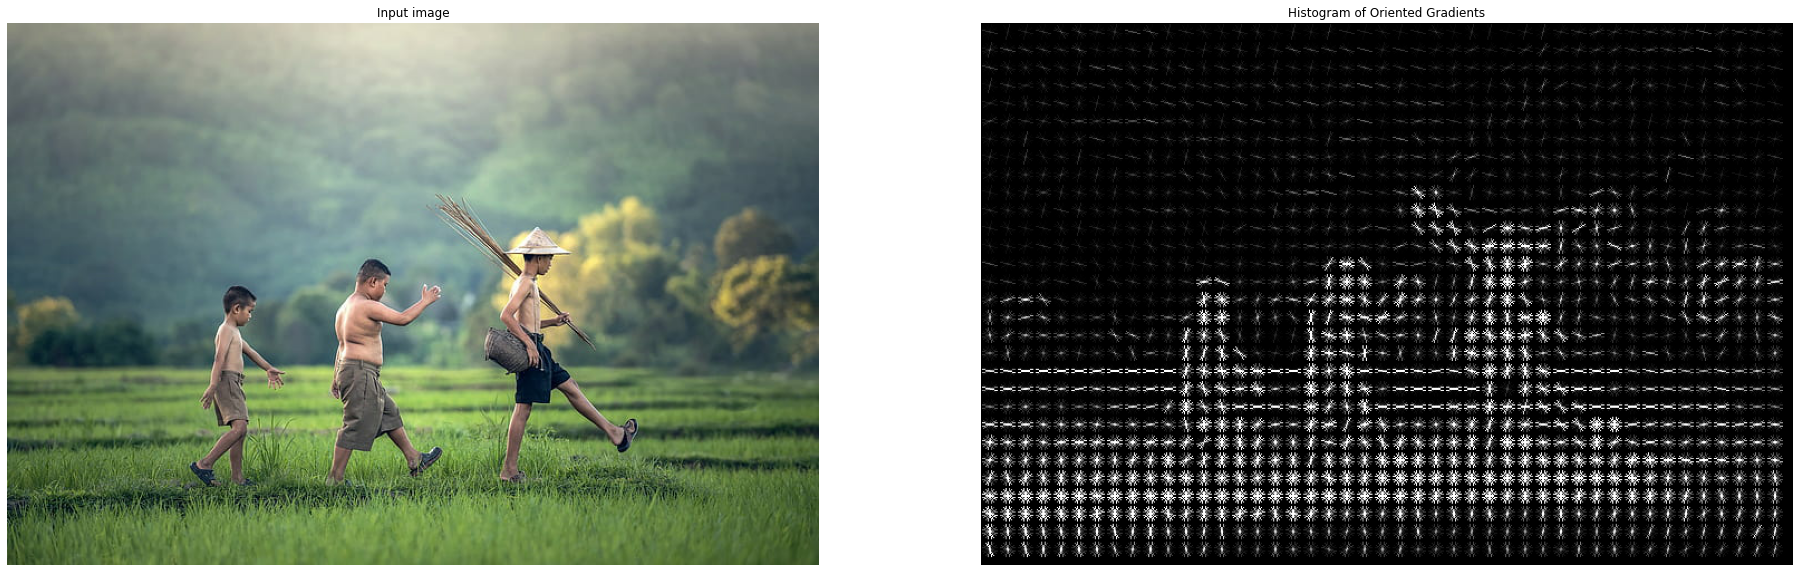

In [6]:

image = color.rgb2gray(img)
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(2,2), visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16), sharex=True, sharey=True, )

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box')
plt.show()

#  <a id = 'section4'> <font color='grey'>  4. Model Training </font> </a>

In [9]:
# define parameters of HOG feature extraction
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
threshold = .3

In [10]:
# define path for positive input dataset
pos_im_path = r"datasets/positive" 

# define the path for negative input dataset
neg_im_path= r"datasets/negative"


In [11]:
# read the image files:
pos_im_listing = os.listdir(pos_im_path) # it will read all the files in the positive image path (so all the required images)
neg_im_listing = os.listdir(neg_im_path)
num_pos_samples = size(pos_im_listing) # simply states the total no. of images
num_neg_samples = size(neg_im_listing)
print(num_pos_samples) # prints the number value of the no.of samples in positive dataset
print(num_neg_samples)
data= []
labels = []

2416
4145


In [12]:
# compute HOG features and label them:

#this loop enables reading the files in the pos_im_listing variable one by one
for file in pos_im_listing:
    img = Image.open(pos_im_path + '\\' + file) 
    #img = img.resize((64,128))
    gray = img.convert('L') # convert the image into single channel i.e. RGB to grayscale
    # calculate HOG for positive features
    fd = hog(gray, orientations, pixels_per_cell, cells_per_block, feature_vector=True)# fd= feature descriptor
    data.append(fd)
    labels.append(1)
    
# Same for the negative images
for file in neg_im_listing:
    img= Image.open(neg_im_path + '\\' + file)
    #img = img.resize((64,128))
    gray= img.convert('L')
    # Now we calculate the HOG for negative features
    fd = hog_nd(gray, orientations, pixels_per_cell, cells_per_block, feature_vector=True) 
    data.append(fd)
    labels.append(0)

In [13]:
# encode the labels, converting them from strings to integers
le = LabelEncoder()
labels = le.fit_transform(labels)

In [14]:
# Partitioning the data into training and testing splits, using 80%
# of the data for training and the remaining 20% for testing
print(" Constructing training/testing split...")
(trainData, testData, trainLabels, testLabels) = train_test_split(np.array(data), labels, test_size=0.20, random_state=42)

 Constructing training/testing split...


In [15]:
print(" Training Linear SVM classifier...")
model = LinearSVC()
model.fit(trainData, trainLabels)

 Training Linear SVM classifier...


H:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC()

In [16]:
print(" Evaluating classifier on test data ...")
predictions = model.predict(testData)
print(classification_report(testLabels, predictions))

 Evaluating classifier on test data ...
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       830
           1       0.89      0.88      0.88       483

    accuracy                           0.91      1313
   macro avg       0.91      0.91      0.91      1313
weighted avg       0.91      0.91      0.91      1313



In [17]:
# Save the model:
joblib.dump(model, 'models/model_person.npy')

['models/model_person.npy']

#  <a id = 'section5'> <font color='grey'>  5. Testing the Model </font> </a>

In [33]:
#Define HOG Parameters
# change them if necessary to orientations = 8, pixels per cell = (16,16), cells per block to (1,1) for weaker HOG
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2,2)
threshold = .3

In [26]:
# define the sliding window:
def sliding_window(image, stepSize, windowSize):# image is the input, step size is the no.of pixels needed to skip and windowSize is the size of the actual window
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):# this line and the line below actually defines the sliding part and loops over the x and y coordinates
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y: y + windowSize[1], x:x + windowSize[0]])

In [27]:
# Upload the saved svm model:
model = joblib.load('models/model_person.npy')

In [47]:
# Test the trained classifier on an image below!
scale = 0
detections = []
# read the image you want to detect the object in:
img= cv2.imread("test/test1.jpg")

In [48]:
# Try it with image resized if the image is too big
img= cv2.resize(img,(300,200))

In [49]:
# defining the size of the sliding window (has to be, same as the size of the image in the training data)
(winW, winH)= (64,128)
windowSize=(winW,winH)
downscale=1.5

In [50]:
# Apply sliding window:
for resized in pyramid_gaussian(img, downscale=1.5): 
    for (x,y,window) in sliding_window(resized, stepSize=10, windowSize=(winW,winH)):
       
        if window.shape[0] != winH or window.shape[1] !=winW: 
            continue
        #window=color.rgb2gray(window)
        fds = hog_nd(window, orientations, pixels_per_cell, cells_per_block)  # extract HOG features from the window captured
        fds = fds.reshape(1, -1)
        pred = model.predict(fds) # use the SVM model to make a prediction on the HOG features extracted from the window
        
        if pred == 1:
            if model.decision_function(fds) > 0.6: 
                print("Detection:: Location -> ({}, {})".format(x, y))
                print("Scale ->  {} | Confidence Score {} \n".format(scale,model.decision_function(fds)))
                detections.append((int(x * (downscale**scale)), int(y * (downscale**scale)), model.decision_function(fds),
                                   int(windowSize[0]*(downscale**scale)), # create a list of all the predictions found
                                      int(windowSize[1]*(downscale**scale))))
    scale+=1
    
clone = resized.copy()

Detection:: Location -> (170, 30)
Scale ->  0 | Confidence Score [0.7704486] 

Detection:: Location -> (50, 40)
Scale ->  0 | Confidence Score [0.70594479] 

Detection:: Location -> (100, 40)
Scale ->  0 | Confidence Score [1.06341251] 

Detection:: Location -> (170, 40)
Scale ->  0 | Confidence Score [2.33477458] 



In [51]:
# this peice of code creates a raw bounding box prior to using NMS
for (x_tl, y_tl, _, w, h) in detections:
    cv2.rectangle(img, (x_tl, y_tl), (x_tl + w, y_tl + h), (0, 0, 255), thickness = 2)
rects = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections]) # do nms on the detected bounding boxes
sc = [score[0] for (x, y, score, w, h) in detections]
print("detection confidence score: ", sc)
sc = np.array(sc)
pick = non_max_suppression(rects, probs = sc, overlapThresh = 0.3)

# this piece of code creates a bounding box after using nms on the detections
for (xA, yA, xB, yB) in pick:
    cv2.rectangle(img, (xA, yA), (xB, yB), (0,191,255), 2)
    cv2.putText(img,'Person',(xA-2,yA-2),1,0.75,(255,12,34),1)
cv2.imshow("Raw Detections after NMS", img)

# Save the images below
k= cv2.waitKey(0) & 0xFF 
if k == 27:             #wait for ESC key to exit
    cv2.destroyAllWindows()
elif k == ord('s'):
    cv2.imwrite('cache/test.jpg',img)
    cv2.destroyAllWindows()

detection confidence score:  [0.770448595377178, 0.7059447901445348, 1.063412507675345, 2.3347745804012296]
